In [3]:
import networkx as nx
import matplotlib.pyplot as plt

In [281]:
"""
이게 유의미한지를 평가하기 위해서, 일단 필터링하지 않은 데이터지만 한번 해본다.
어떤 distance가 좋은지, 뭐 그런걸 알아야 하니까. 
"""
import pandas as pd
import itertools

excel_path_and_filename = "../../../Downloads/SMEs_Scopus_2013-2017.xlsx"
df = pd.read_excel(excel_path_and_filename)
df = df[['Author Keywords', 'Year', 'Abstract', 'Index Keywords']]

auth_kwd_lst = list(df['Author Keywords'].dropna().apply(lambda s: s.strip().split(";")))
auth_kwd_lst = map(lambda ks: [k.strip().lower() for k in ks], auth_kwd_lst)
auth_kwd_lst = list(auth_kwd_lst)
print(auth_kwd_lst[:10])

[['csfs', 'factor analysis', 'indian manufacturing smes', 'six sigma'], ['energy recovery', 'muzzle arc', 'pulsed supply', 'railgun', 'superconducting magnetic energy storage', 'system efficiency', 'termination discharge'], ['internationalization', 'market research', 'organic olive oil', 'smes', 'tourist'], ['contractors', 'entrepreneurship', 'indonesia', 'smes'], ['bpgm-sme', 'improved ukf', 'multi-target tracking', 'tracking accuracy'], ['dark triad of personality', 'entrepreneurial orientation (eo)', 'executive personality', 'small and medium-sized enterprise (sme)'], ['automated testing', 'electrical cable hardness', 'modular systems', 'small- and medium-sized enterprise (smes)', 'system adaptability', 'system automation', 'system flexibility'], ['dimension of information quality', 'quality information', 'smes'], ['discrete-event system simulation', 'productivity improvement', 'sme'], ['productivity', 'standard time', 'theory of constraint']]


In [207]:
import collections 

def make_auth_kwd_lst():
    auth_kwd_lst = list(df['Author Keywords'].dropna().apply(lambda s: s.strip().split(";")))
    auth_kwd_lst = map(lambda ks: [k.strip().lower() for k in ks], auth_kwd_lst)
    auth_kwd_lst = list(auth_kwd_lst)

    auth_kwd_lst = map(lambda x: sorted(x), auth_kwd_lst)
    make_edge = lambda ks: [ (ks[i], ks[j]) for i in range(0, len(ks)-1) for j in range(i+1, len(ks))]
    auth_kwd_lst = itertools.chain.from_iterable(map(lambda x: make_edge(x), auth_kwd_lst))
    return auth_kwd_lst
auth_kwd_lst = make_auth_kwd_lst()
#print(list(itertools.chain.from_iterable(map(lambda x: list(x), auth_kwd_lst)))[:10])

kwdG = nx.Graph()
kwdG.add_nodes_from(
    [(n[0], {'weight':n[1]}) for n in collections.Counter(itertools.chain.from_iterable(auth_kwd_lst)).most_common()]
)
auth_kwd_lst = make_auth_kwd_lst()
kwdG.add_edges_from(
    [(e[0][0], e[0][1], {'weight':e[1]}) for e in collections.Counter(auth_kwd_lst).most_common()]
)

print(len(kwdG.nodes()))
for n in kwdG.copy().nodes(data=True):
    """
    일정 이상의 weight를 가지고 있지 않은 node의 경우는 feature로서의 성질을 가지고 있지 못하다고 파악하기 때문에 제외한다. 
    차원을 늘린다고 해서 더 좋아지는 것은 아님. 당연한 이야기지만, 노이즈가 늘어나기 때문에, 너무 늘리지 않고 적절한 선에서 진행하는 것이 필요.
    아래에서, distance가 가까운 순으로 확인할 때, 너무 많은 dimension으로 표현될 경우에는 오히려 뜬금없는 키워드끼리 가깝다고 나오는 경우가 있음. 
    """
    if n[1]['weight'] <=100: 
        kwdG.remove_node(n[0])

"""
계산의 편의를 위해서 일정 weight 이하인 edge를 삭제하고 
고립된 노드 또한 삭제함 
이 네트워크를 활용해서 거리를 재보면 어떻게 나올까? 비슷한 의미를 가진 keyword는 비슷한 관계로 나올까? 
"""
print(len(kwdG.nodes()))
#print(kwdG.edges(data=True))

24184
205


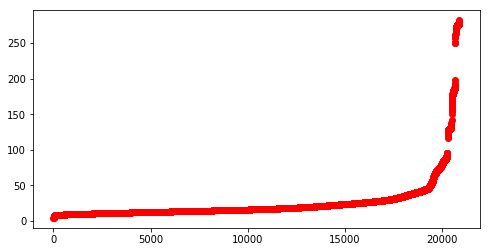

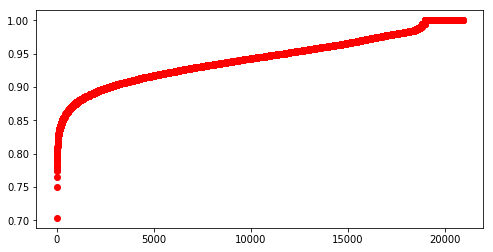

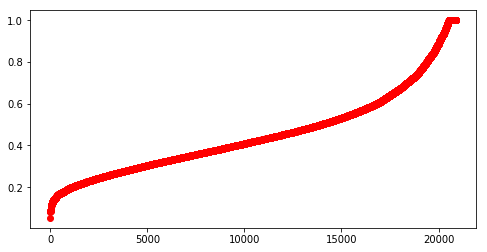

In [226]:
from sklearn.preprocessing import MinMaxScaler

def kwkw_mat_from_G(inputG):
    node_to_node_mat = {n1:{n2:0 for n2 in inputG.nodes()} for n1 in inputG.nodes()}
    for e in inputG.edges(data=True):
        node_to_node_mat[e[0]][e[1]] = e[2]['weight']
        node_to_node_mat[e[1]][e[0]] = e[2]['weight']
    """scaling by column 
    """
    df = pd.DataFrame(node_to_node_mat)
    #df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns, index=df.columns)#scaling
    return df

from scipy.spatial.distance import euclidean, correlation, jaccard, hamming, cosine, mahalanobis
"""
sparse한 관계이기 때문에 jaccard를 이용하는 것이 필요함
"""
km = kwkw_mat_from_G(kwdG)
def plot_distance_dist(inputKKM, dist_metric_func):
    KKdist_dist = []
    for i in range(0, len(inputKKM)-1):
        for j in range(i+1, len(inputKKM)):
            KKdist_dist.append(
                (inputKKM.columns[i], inputKKM.columns[j], dist_metric_func(inputKKM.iloc()[i], inputKKM.iloc()[j]))
            ) 
    plt.figure(figsize=(8, 4))
    dist_dist = [d for k1, k2, d in KKdist_dist]
    plt.plot(sorted(dist_dist), 'ro')
    plt.show()
    return sorted(KKdist_dist, key=lambda x: x[2])
"""
분포를 보면, 일단 euclidean과 correlation의 경우는 표준화가 되어 있지 않음. 
따라서 일단 개별 column에 대해서 표준화를 진행하는 것이 필요함.
mahalanobis 의 경우는 covariance matrix 를 함께 넘겨주어야 함. 
그래서 어떻게 covariance matrix 를 구하지!!
"""
each_dist_lst = []
for dist_func in [euclidean, jaccard, cosine]:
    each_dist_lst.append( plot_distance_dist(km, dist_func) )

In [240]:
KKdist_dist = []
for i in range(0, len(km)-1):
    for j in range(i+1, len(km)):
        KKdist_dist.append(
            (km.columns[i], km.columns[j], mahalanobis(km.iloc()[i], km.iloc()[j], np.cov(km)))
        )
KKdist_dist[:10]

[('absorptive capacity', 'access to finance', 325.61330683165278),
 ('absorptive capacity', 'action research', 426.09528474112756),
 ('absorptive capacity', 'adoption', 260.00090102113671),
 ('absorptive capacity', 'africa', 328.87041408239787),
 ('absorptive capacity', 'ahp', 325.66854007010198),
 ('absorptive capacity', 'australia', 395.25749266690144),
 ('absorptive capacity', 'bankruptcy', 399.57785908514302),
 ('absorptive capacity', 'banks', 340.92153596866086),
 ('absorptive capacity', 'barriers', 166.08628521577759),
 ('absorptive capacity', 'big data', 474.67203457891469)]

In [243]:
KKdist_dist = sorted(KKdist_dist, key=lambda x: x[2])
print(KKdist_dist[:10])

[('shape memory effect', 'superconducting magnetic energy storage (smes)', 3.6104754863709183), ('food industry', 'quality management', 8.3931435659815428), ('quality management', 'thailand', 9.3848122570434054), ('food industry', 'thailand', 9.5854659428211946), ('cloud manufacturing', 'superconducting magnetic energy storage (smes)', 11.275176409295625), ('economic crisis', 'governance', 11.56912562051026), ('cloud manufacturing', 'small- and medium-sized enterprises (smes)', 12.049322755316522), ('information systems', 'literature review', 12.826180408591824), ('economic growth', 'small firms', 13.355600727018267), ('communication', 'risk assessment', 13.571510303490269)]


1.0

In [236]:
mahalanobis([1.0, 1.0, 1.0], [0.0, 0.0, 0.0], [[1.0, 1.0], [1.0, 1.0]])

ValueError: shapes (3,) and (2,2) not aligned: 3 (dim 0) != 2 (dim 0)

In [221]:
# how to make covariance matrix

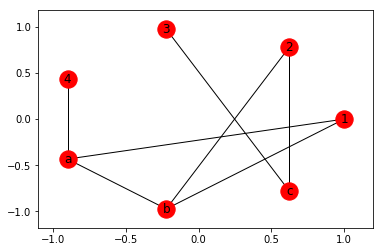

In [253]:
import networkx as nx
from networkx.algorithms import bipartite

B = nx.Graph()

B.add_nodes_from([1, 2, 3, 4], bipartite=0)
B.add_nodes_from(['a', 'b', 'c'], bipartite=1)

B.add_edges_from([(1, 'a'), (1, 'b'), (2, 'b'), (2, 'c'), (3, 'c'), (4, 'a')])
"""
bipartite 하게 한다고 해서, 아래처럼 B.add_edges_from 을 했을 때 막아주는 것도 아님....
그럼 뭐하러 bipartite를 설정하나? 

bipartite 한 group a, b가 exclusive 하면 좋겠지만, 그렇지 않은 상황도 있을 수 있으니까, 
예를 들어서, author keyword <==> index keywords 인 경우들처럼. 
그럼 이럴 때는 node attr dict로 구분을 하고 진행해야 하는건가?? 그리고 만약 서로 같은 node type일 경우에는 해당 edge를 지워 버리는 식으로?? 
"""
B.add_edges_from([('a', 'b')])

B.nodes(data=True)

nx.draw_networkx(B, nx.shell_layout(B))
plt.show()

[('a', {}), ('b', {}), ('c', {}), ('d', {})]
True


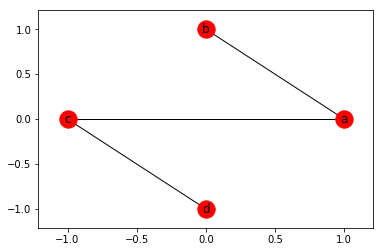

In [259]:
import networkx as nx
from networkx.algorithms import bipartite



"""
bipartite 하게 한다고 해서, 아래처럼 B.add_edges_from 을 했을 때 막아주는 것도 아님....
그럼 뭐하러 bipartite를 설정하나? 

bipartite 한 group a, b가 exclusive 하면 좋겠지만, 그렇지 않은 상황도 있을 수 있으니까, 
예를 들어서, author keyword <==> index keywords 인 경우들처럼. 
그럼 이럴 때는 node attr dict로 구분을 하고 진행해야 하는건가?? 그리고 만약 서로 같은 node type일 경우에는 해당 edge를 지워 버리는 식으로?? 
"""
B = nx.Graph()
#B.add_nodes_from(['a', 'b', 'c'])
B.add_edges_from(
    [('a', 'b'), ('a', 'c'), ('d', 'c')]
                )

print(B.nodes(data=True))
"""
굳이 node에 bipartite 한 attr가 포함되어 있지 않더라도, `nx.is_bipartite(B)를 통해서 체크할 수 있음. 
음 node의 이름은 같은데 type이 다른 경우에는?? 
결국 이렇다면, 
"""
print(nx.is_bipartite(B))
nx.draw_networkx(B, nx.shell_layout(B))
plt.show()

In [262]:
"""
같은 이름인 경우에는, type이 달라도 같은 노드로 인지함. 사실 이게 더 합리적인 경우이기는 한데, 
author keyword ==> index keyword 일때, 서로 다른 노드로 고려해야 하지 않나. 흠. 
"""
B = nx.Graph()
B.add_nodes_from([('a', {'type':1}), ('b', {'type':2}), ('b', {'type':1})])
B.nodes(data=True)

NodeDataView({'a': {'type': 1}, 'b': {'type': 1}})

In [339]:
def basic_filtering_for_series(input_series):
    r_s = input_series.fillna("").apply(lambda s: s.strip().lower())
    r_s = r_s.apply(lambda s: s.split(";"))
    # remove special char and remove space 
    def change_word(in_w):
        r_c = []
        for c in in_w:
            if 'a' <= c <= 'z' or '0' <= c <='9' or c==' ':
                r_c.append(c)
        return "".join(r_c).strip()
    r_s = r_s.apply(lambda ks: list(filter(lambda k: True if k!="" else False, map(change_word, ks))))
    return r_s
auth_col = basic_filtering_for_series(df['Author Keywords'])
index_col = basic_filtering_for_series(df['Index Keywords'])
auth_index_df = pd.DataFrame({"auth_kwd":auth_col, "index_kwd":index_col})

biG = nx.Graph()
edge_lst = []
for i in range(0, len(auth_index_df)):
    auth_l = list(auth_index_df['auth_kwd'].iloc()[i])
    index_l = list(auth_index_df['index_kwd'].iloc()[i])
    if len(auth_l) != 0 and len(index_l)!=0:
        edge_lst += [ (auth, ind+"(i)") for auth in auth_l for ind in index_l ]
print(len(edge_lst))
# add node
for e in collections.Counter(edge_lst).most_common():
    auth_node, ind_node = e[0][0], e[0][1]
    e_weight = e[1]
    for node in [auth_node, ind_node]:
        if node in biG.nodes():
            biG.nodes(data=True)[node]['weight'] = biG.nodes(data=True)[node]['weight'] + e_weight
        else:
            biG.add_nodes_from([(node, {'weight':e_weight})])
# add edges

biG.add_edges_from(
    (e[0][0], e[0][1], {'weight':e[1]}) for e in collections.Counter(edge_lst).most_common()
)
print("complete")
rawBiG = biG.copy()

369965
complete


In [470]:
biG = rawBiG.copy()
print("is bipartite?: {}".format(nx.is_bipartite(biG)))
#left, right = nx.bipartite.sets(biG)
# drop thw low nodes
print("before filtering node size: {}".format(len(biG.nodes())))
for n in biG.copy().nodes(data=True):
    if n[1]['weight'] < 100: # 쓸데없는 node들을 삭제합니다. 
        biG.remove_node(n[0])
print("after filtering node size: {}".format(len(biG.nodes())))
nodesetA, nodesetB = nx.bipartite.sets(biG)
try:
    # need row order, 
    biadj_matrix = nx.algorithms.bipartite.biadjacency_matrix(biG, row_order=nodesetA)
except:
    print("not yet")
    
print()
bi_df = pd.DataFrame(biadj_matrix.toarray(), index=nodesetA, columns=nodesetB)
bi_df = bi_df.apply(lambda col: (col - 0)/(col.max() - col.min()))# scaling by column
n_n_dist_lst  = [
    ( bi_df.index[i], bi_df.index[j], euclidean(bi_df.iloc()[j], bi_df.iloc()[i]) ) 
    for i in range(0, len(bi_df)-1) for j in range(i+1, len(bi_df))
]

for nn in sorted(n_n_dist_lst, key=lambda x: x[2], reverse=True)[:10]:
    print(nn)

is bipartite?: True
before filtering node size: 38369
after filtering node size: 791

('smes', 'shape memory effect', 15.436279758020806)
('shape memory alloys', 'smes', 15.313835112256491)
('smes', 'apoptosis', 15.297551958555223)
('antioxidant', 'smes', 15.297110857498893)
('smes', 'martensitic transformation', 15.28047904820015)
('biodiesel', 'smes', 15.252823023508066)
('platinum', 'smes', 15.250537382105268)
('smes', 'crystal structure', 15.24602190003883)
('xray diffraction', 'smes', 15.228784583558754)
('oxidative stress', 'smes', 15.22873389330548)
